In [1]:
import pandas as pd 
from datetime import datetime
from pytz import timezone
import numpy as np
import csv 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Reading the .csv Files

In [2]:
# does not read the csv file correctly for sleep; what do the columns mean when they're just numbers?
sleep_data = pd.read_csv('scripps1_sleep.csv')
motion_data = pd.read_csv('scripps1_motion.csv',sep=';')
ibi_data = pd.read_csv('scripps1_ibi.csv',sep=';')

While there are no issues with reading the data for motion and ibi, the sleep file seemed to have issues. I initially thought that it was due to the seperator being something different than ;, but upon further analysis I realized that there weren't enough columns for each row.

In [3]:
test = open('scripps1_sleep.csv','r')
lines = test.readlines()
list_lengths = [] 
list_rows = [] 
for i in lines: 
    list_rows.append(i.strip().split(';'))

In [4]:
def sleep_dataset_reader(str_dataset):
    test = open(str_dataset,'r')
    lines = test.readlines()
    columns = len(lines[0].strip().split(';'))
    cleaned_data = [] 
    for i in list_rows:
        cleaned_data.append(i[:columns])
    for row in cleaned_data:
        row.extend(0 for x in range(columns-len(row)))
    headers = cleaned_data.pop(0)
    df = pd.DataFrame(cleaned_data,columns = headers,dtype='float')
    df.replace(r'^\s*$', np.nan, regex=True, inplace = True)
    return df

In [10]:
df = sleep_dataset_reader('scripps1_sleep.csv')

In [14]:
def dataset_cleaner(dataset):
    df = dataset.copy()
    df['Date'] =  pd.to_datetime(df['Date'], format='%d.%m.%Y')
    df['Bedtime start Unix'] = pd.to_datetime(df['Bedtime start Unix'],unit='s')
    df['Bedtime end Unix'] = pd.to_datetime(df['Bedtime end Unix'],unit='s')
    df = df.drop(['Bedtime start','Bedtime end'],axis=1)
    df = df[df['Debug info'] != 'Bedtime detection failed']
    str_list = list(filter(None, list(df.columns)))
    return df[str_list]

In [16]:
new_df = dataset_cleaner(df)
new_df.head()

,Date,Bedtime start Unix,Bedtime end Unix,TimeZone,Debug info,Battery consumption,Is longest,Time in bed,Sleep Score,Sleep minutes,...,890,891,892,893,894,895,896,897,898,899
0,2018-11-27,2018-11-27 20:35:53,2018-11-27 20:49:53,-8.0,NaN,NaN,1.0,14.0,23.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-11-27,2018-11-28 01:17:55,2018-11-28 01:37:55,-8.0,NaN,NaN,1.0,20.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-11-28,2018-11-28 06:16:15,2018-11-28 15:32:15,-8.0,NaN,1.2%,1.0,556.0,94.0,514.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
3,2018-11-28,2018-11-28 20:52:26,2018-11-28 21:12:26,-8.0,NaN,NaN,0.0,20.0,25.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-11-29,2018-11-29 03:44:43,2018-11-29 03:54:43,-8.0,NaN,NaN,1.0,10.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def naps_and_sleep(df):
    naps = df[df['Sleep minutes']<30]
    sleep = df[df['Sleep minutes']>=30]
    return naps,sleep

In [21]:
area_interest = new_df.iloc[:,6:35].dropna(how='all',axis = 1).drop('SleepMidPoint',axis=1)
test = area_interest.apply(pd.to_numeric)
test.head()

,Is longest,Time in bed,Sleep Score,Sleep minutes,Wake minutes,REM minutes,Light minutes,Deep minutes,Efficiency,Lowest HR time minutes,...,Temperature,Restless%,Got up count,Score Total,Score Deep,Score REM,Score Efficiency,Score Latancy,Score Disturbances,Score Alignment
0,1.0,14.0,23.0,4.0,10.0,0.0,4.0,0.0,29.0,6.0,...,0.0,102.0,0.0,1.0,1.0,1.0,1.0,76.0,99.0,1.0
1,1.0,20.0,23.0,0.0,20.0,0.0,0.0,0.0,0.0,8.0,...,0.0,NaN,0.0,1.0,1.0,1.0,1.0,76.0,99.0,1.0
2,1.0,556.0,94.0,514.0,43.0,212.0,230.0,73.0,92.0,102.0,...,36.7,38.0,0.0,97.0,82.0,100.0,98.0,96.0,81.0,100.0
3,0.0,20.0,25.0,10.0,11.0,0.0,10.0,0.0,48.0,8.0,...,36.7,86.0,0.0,1.0,1.0,1.0,19.0,82.0,99.0,1.0
4,1.0,10.0,23.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,36.7,NaN,0.0,1.0,1.0,1.0,1.0,76.0,99.0,6.0


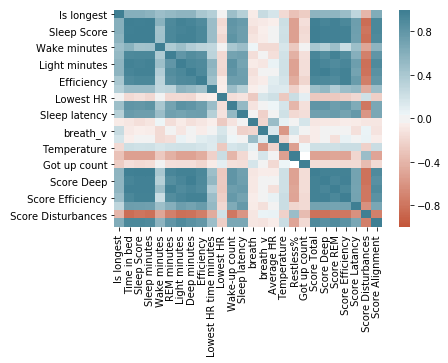

In [20]:
corr = test.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
);

In [113]:
#nap, sleep = naps_and_sleep(new_df)

Looking at the header line, I noticed that there were a lot of columns with just numbers, and looking at some of the longer rows I saw that there were many repetitions of numbers. I made the judgement call to remove any column that was just numbers. This was both to conserve space (which will become a major issue when analyzing monthly data), but also because I didn't know how to interpret columns with just numbers as the header, and as a result thought that those columns would be unnecessary. Ideally, this is a temporary fix; looping through lists of texts take a long time, and I'd hope to either a) eventually figure out a way to use .read_csv() to read only certain parts of each line or b) figure out what the number columns mean and determine whether it's a good idea to remove them or not. For now, because all the categories of interest are named, I've decided to clean the .csv file before reading it. Here are some methods used to do so: 

In [67]:
def header_col_selector(header_line):
    important_cols = header_line.strip().split(';')
    no_integers = [x for x in important_cols if not x.isdigit()]
    return len(no_integers)

In [68]:
def list_lines(lines, col_length):
    text_to_csv = [] 
    for i in lines:
        text_to_csv.append(i.strip().split(';')[0:col_length])
    return text_to_csv

In [69]:
def sleep_cleaner(sleep_csv):
    # Overall function used to clean the sleep_cleaner 
    # input: sleep_csv: the file name as a string
    # returns: returns nothing, but creates a modified csv that has cleaner columns to work with 
    file = open(sleep_csv,'r')
    lines = file.readlines()
    header_line = lines[0]
    columns = header_col_selector(header_line)
    text_list = list_lines(lines,columns)
    with open('modified_scripps1_sleep.csv','w') as f:
        writer = csv.writer(f)
        writer.writerows(text_list)

In [70]:
sleep_cleaner('scripps1_sleep.csv')
sleep_data = pd.read_csv('modified_scripps1_sleep.csv')

# A sneakpeak at all the datasets  

## Sleep Data

In [71]:
sleep_data.head()

,Date,Bedtime start Unix,Bedtime end Unix,Bedtime start,Bedtime end,TimeZone,Debug info,Battery consumption,Is longest,Time in bed,...,Unnamed: 29,Score Total,Score Deep,Score REM,Score Efficiency,Score Latancy,Score Disturbances,Score Alignment,FW version,Sleep phases
0,27.11.2018,1543350953,1543351793,12:35:53,12:49:53,-8,NaN,NaN,1.0,14.0,...,NaN,1.0,1.0,1.0,1.0,76.0,99.0,1.0,NaN,NaN
1,27.11.2018,1543367875,1543369075,17:17:55,17:37:55,-8,NaN,NaN,1.0,20.0,...,NaN,1.0,1.0,1.0,1.0,76.0,99.0,1.0,NaN,NaN
2,28.11.2018,1543385775,1543419135,22:16:15,7:32:15,-8,NaN,1.2%,1.0,556.0,...,NaN,97.0,82.0,100.0,98.0,96.0,81.0,100.0,NaN,NaN
3,28.11.2018,1543438346,1543439546,12:52:26,13:12:26,-8,NaN,NaN,0.0,20.0,...,NaN,1.0,1.0,1.0,19.0,82.0,99.0,1.0,NaN,NaN
4,29.11.2018,1543463083,1543463683,19:44:43,19:54:43,-8,NaN,NaN,1.0,10.0,...,NaN,1.0,1.0,1.0,1.0,76.0,99.0,6.0,NaN,NaN


Sleep data has by far the most amount of information, and as a result will require the most cleaning. I don't know what all the columns are yet, so I went ahead and decided to take a look.

In [72]:
sleep_data.columns

Index(['Date', 'Bedtime start Unix', 'Bedtime end Unix', 'Bedtime start',
       'Bedtime end', 'TimeZone', 'Debug info', 'Battery consumption',
       'Is longest', 'Time in bed', 'Sleep Score', 'Sleep minutes',
       'Wake minutes', 'REM minutes', 'Light minutes', 'Deep minutes',
       'Efficiency', 'Lowest HR time minutes', 'Lowest HR', 'Wake-up count',
       'Sleep latency', 'breath', 'breath_v', 'Average HR', 'SleepMidPoint',
       'Temperature', 'Unnamed: 26', 'Restless%', 'Got up count',
       'Unnamed: 29', 'Score Total', 'Score Deep', 'Score REM',
       ' Score Efficiency', ' Score Latancy', ' Score Disturbances',
       'Score Alignment', 'FW version', 'Sleep phases'],
      dtype='object')

There are some repetitive columns that aren't very useful (such as Betime start/end unix). I also noticed that there were instances where if Debug info has 'Bedtime detection failed' then no information will be collected, essentially making the column useless. As a result, here's a cleaned up version.

In [96]:
# removes rows that have empty data 
cleaned_sleep_data = sleep_data.drop(sleep_data[sleep_data['Debug info']=='Bedtime detection failed'].index).reset_index(drop=True)
# removing extraneous columns and unknown columns 
cleaned_sleep_data = cleaned_sleep_data.drop(['Bedtime start Unix','Bedtime end Unix','Debug info'],axis=1)
cols = [c for c in cleaned_sleep_data.columns if 'unnamed' not in c.lower()]
cleaned_sleep_data = cleaned_sleep_data[cols]

In [97]:
cleaned_sleep_data.head()

,Date,Bedtime start,Bedtime end,TimeZone,Battery consumption,Is longest,Time in bed,Sleep Score,Sleep minutes,Wake minutes,...,Got up count,Score Total,Score Deep,Score REM,Score Efficiency,Score Latancy,Score Disturbances,Score Alignment,FW version,Sleep phases
0,27.11.2018,12:35:53,12:49:53,-8,NaN,1.0,14.0,23.0,4.0,10.0,...,0.0,1.0,1.0,1.0,1.0,76.0,99.0,1.0,NaN,NaN
1,27.11.2018,17:17:55,17:37:55,-8,NaN,1.0,20.0,23.0,0.0,20.0,...,0.0,1.0,1.0,1.0,1.0,76.0,99.0,1.0,NaN,NaN
2,28.11.2018,22:16:15,7:32:15,-8,1.2%,1.0,556.0,94.0,514.0,43.0,...,0.0,97.0,82.0,100.0,98.0,96.0,81.0,100.0,NaN,NaN
3,28.11.2018,12:52:26,13:12:26,-8,NaN,0.0,20.0,25.0,10.0,11.0,...,0.0,1.0,1.0,1.0,19.0,82.0,99.0,1.0,NaN,NaN
4,29.11.2018,19:44:43,19:54:43,-8,NaN,1.0,10.0,23.0,0.0,10.0,...,0.0,1.0,1.0,1.0,1.0,76.0,99.0,6.0,NaN,NaN


## Motion Data

In [89]:
motion_data.head()

,Unix time,Date,Time,Motion seconds,NTC temp,Ring state,Motions low,Motions high,Regularity,Average Y,Average Z
0,1543340132,27.11.2018,9:35:32,6,37.69,3,7,1,0,256.0,-64.0
1,1543340162,27.11.2018,9:36:02,11,37.69,3,9,2,0,-8.0,-248.0
2,1543340192,27.11.2018,9:36:32,16,32.63,3,19,4,0,-256.0,-336.0
3,1543340222,27.11.2018,9:37:02,8,32.63,3,8,1,0,-152.0,-744.0
4,1543340252,27.11.2018,9:37:32,2,30.59,3,2,1,0,424.0,-472.0


The dataset's pretty clean, the only thing that's unnecessary is unix time.

In [92]:
cleaned_motion_data = motion_data.drop('Unix time',axis=1)

## IBI Data

In [10]:
ibi_data.head()

,Date,Time,Validity,Padded IBI,IBI,UTC time
0,27.11.2018,12:37:43,0,1312,1312.0,1.543351e+09
1,27.11.2018,12:37:43,1,980,980.0,1.543351e+09
2,27.11.2018,12:37:43,1,956,956.0,1.543351e+09
3,27.11.2018,12:37:43,1,1096,1096.0,1.543351e+09
4,27.11.2018,12:37:43,1,1172,1172.0,1.543351e+09


This dataset is also pretty clean, just need to remove UTC time.

In [94]:
cleaned_ibi_data = ibi_data.drop('UTC time',axis=1)

In [99]:
cleaned_sleep_data.head()

,Date,Bedtime start,Bedtime end,TimeZone,Battery consumption,Is longest,Time in bed,Sleep Score,Sleep minutes,Wake minutes,...,Got up count,Score Total,Score Deep,Score REM,Score Efficiency,Score Latancy,Score Disturbances,Score Alignment,FW version,Sleep phases
0,27.11.2018,12:35:53,12:49:53,-8,NaN,1.0,14.0,23.0,4.0,10.0,...,0.0,1.0,1.0,1.0,1.0,76.0,99.0,1.0,NaN,NaN
1,27.11.2018,17:17:55,17:37:55,-8,NaN,1.0,20.0,23.0,0.0,20.0,...,0.0,1.0,1.0,1.0,1.0,76.0,99.0,1.0,NaN,NaN
2,28.11.2018,22:16:15,7:32:15,-8,1.2%,1.0,556.0,94.0,514.0,43.0,...,0.0,97.0,82.0,100.0,98.0,96.0,81.0,100.0,NaN,NaN
3,28.11.2018,12:52:26,13:12:26,-8,NaN,0.0,20.0,25.0,10.0,11.0,...,0.0,1.0,1.0,1.0,19.0,82.0,99.0,1.0,NaN,NaN
4,29.11.2018,19:44:43,19:54:43,-8,NaN,1.0,10.0,23.0,0.0,10.0,...,0.0,1.0,1.0,1.0,1.0,76.0,99.0,6.0,NaN,NaN


# Exploration

Because the sleep dataframe has the most amount of data, I'll primarily be working on that data set.

In [113]:
naps = cleaned_sleep_data[cleaned_sleep_data['Sleep minutes']<120]
rest = cleaned_sleep_data[cleaned_sleep_data['Sleep minutes']>=120]

In [110]:
cleaned_sleep_data.columns

Index(['Date', 'Bedtime start', 'Bedtime end', 'TimeZone',
       'Battery consumption', 'Is longest', 'Time in bed', 'Sleep Score',
       'Sleep minutes', 'Wake minutes', 'REM minutes', 'Light minutes',
       'Deep minutes', 'Efficiency', 'Lowest HR time minutes', 'Lowest HR',
       'Wake-up count', 'Sleep latency', 'breath', 'breath_v', 'Average HR',
       'SleepMidPoint', 'Temperature', 'Restless%', 'Got up count',
       'Score Total', 'Score Deep', 'Score REM', ' Score Efficiency',
       ' Score Latancy', ' Score Disturbances', 'Score Alignment',
       'FW version', 'Sleep phases'],
      dtype='object')

In [115]:
def important_statistics(df):
    areas_of_interest = ['Time in bed','Sleep Score','Sleep minutes','Wake minutes','Wake-up count','Score Total']
    return df[areas_of_interest].describe()

In [116]:
important_statistics(naps)

,Time in bed,Sleep Score,Sleep minutes,Wake minutes,Wake-up count,Score Total
count,20.0000,20.000000,20.000000,20.000000,20.0,19.0
mean,27.7000,22.750000,2.600000,25.300000,0.0,1.0
std,19.4452,5.838845,4.121829,20.640022,0.0,0.0
min,3.0000,0.000000,0.000000,3.000000,0.0,1.0
25%,12.7500,23.000000,0.000000,10.000000,0.0,1.0
50%,21.0000,23.500000,0.000000,13.500000,0.0,1.0
75%,44.0000,24.250000,4.750000,44.000000,0.0,1.0
max,80.0000,31.000000,12.000000,80.000000,0.0,1.0


In [117]:
important_statistics(rest)

,Time in bed,Sleep Score,Sleep minutes,Wake minutes,Wake-up count,Score Total
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,505.533333,82.933333,438.333333,67.800000,2.200000,79.666667
std,54.487045,7.869168,55.550063,49.852927,1.264911,13.226957
min,352.000000,67.000000,321.000000,16.000000,0.000000,51.000000
25%,485.000000,79.000000,414.500000,38.000000,1.000000,74.000000
50%,499.000000,85.000000,446.000000,54.000000,2.000000,82.000000
75%,541.000000,88.500000,471.500000,72.000000,3.000000,88.000000
max,579.000000,94.000000,514.000000,223.000000,5.000000,97.000000
